# FinOpt: Scenario Optimizer

This notebook loads a financial profile and creates an optimization **scenario**:
- **Goals**: Financial targets with confidence levels
- **Withdrawals**: Scheduled cash outflows
- **Optimization**: Find minimum horizon T* and optimal allocation X*

The scenario can be saved and reloaded for reproducibility.

## Setup

In [1]:
# --- Path setup: add project root so "src" is importable ---
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from datetime import date
from pathlib import Path

# --- Standard libs ---
import numpy as np
import pandas as pd

# --- FinOpt modules ---
from src.model import FinancialModel
from src.serialization import load_model, save_scenario, load_scenario
from src.goals import IntermediateGoal, TerminalGoal
from src.withdrawal import WithdrawalEvent, WithdrawalSchedule, WithdrawalModel, StochasticWithdrawal
from src.optimization import CVaROptimizer

---
# 1. Load Financial Profile

Load the profile created in `01-profile-builder.ipynb`.

In [2]:
# --- Load Profile ---

profile_path = Path("../profiles/my_profile.json")

if not profile_path.exists():
    raise FileNotFoundError(
        f"Profile not found at {profile_path}. "
        f"Please run 01-profile-builder.ipynb first."
    )

model = load_model(profile_path)
print(f"Loaded: {model}")
print(f"\nAccounts:")
for i, acc in enumerate(model.accounts):
    print(f"  {i}. {acc.name} (W0=${acc.initial_wealth:,.0f})")

Loaded: FinancialModel(M=3, accounts=['Vivienda', 'Clooney', 'VOO'], cache=enabled)

Accounts:
  0. Vivienda (W0=$1,600,000)
  1. Clooney (W0=$744,747)
  2. VOO (W0=$900,000)


---
# 2. Scenario Configuration

Define the simulation parameters for this scenario.

In [3]:
# --- Scenario Parameters ---

SCENARIO_NAME = "House Purchase 2026"
SCENARIO_DESCRIPTION = "Planning for apartment down payment with emergency fund maintenance"

# Simulation parameters
START_DATE = date(2025, 11, 1)  # When the simulation starts
N_SIMS = 500                     # Monte Carlo scenarios
SEED = 42                        # For reproducibility

# Optimization parameters
T_MAX = 120                      # Maximum horizon to search (months)
SOLVER = "ECOS"                  # CVaROptimizer solver
OBJECTIVE = "balanced"           # Optimization objective

print(f"Scenario: {SCENARIO_NAME}")
print(f"Start date: {START_DATE}")
print(f"Simulations: {N_SIMS}")

Scenario: House Purchase 2026
Start date: 2025-11-01
Simulations: 500


---
# 3. Define Withdrawals

Withdrawals are planned cash outflows from accounts. They reduce portfolio wealth and must be accounted for in the optimization.

**Types:**
- `WithdrawalEvent`: Deterministic withdrawal at a specific date
- `StochasticWithdrawal`: Withdrawal with uncertainty (e.g., variable expenses)

In [4]:
# --- Define Withdrawal Schedule ---

# Scheduled withdrawals (deterministic)
scheduled_withdrawals = WithdrawalSchedule(events=[
    # Housing down payment from savings account
    WithdrawalEvent(
        account="Vivienda",
        amount=2_500_000,
        date=date(2026, 12, 1),
        description="Pie departamento"
    ),
    # Vacation from conservative fund
    WithdrawalEvent(
        account="Clooney",
        amount=800_000,
        date=date(2026, 6, 1),
        description="Vacaciones invierno"
    ),
])

# Stochastic withdrawals (with uncertainty)
stochastic_withdrawals = [
    StochasticWithdrawal(
        account="Clooney",
        base_amount=300_000,
        sigma=100_000,
        date=date(2026, 9, 1),
        floor=100_000,
        cap=600_000,
        seed=42
    ),
]

# Combined withdrawal model
withdrawal_model = WithdrawalModel(
    scheduled=scheduled_withdrawals,
    stochastic=stochastic_withdrawals
)

# Display withdrawal summary
print("=" * 70)
print("WITHDRAWAL SCHEDULE")
print("=" * 70)

print("\nScheduled Withdrawals (Deterministic):")
for event in scheduled_withdrawals.events:
    print(f"  - {event.date.strftime('%Y-%m')}: ${event.amount:,.0f} from {event.account}")
    if event.description:
        print(f"    Purpose: {event.description}")

print("\nStochastic Withdrawals (Variable):")
for w in stochastic_withdrawals:
    timing = f"month {w.month}" if w.month is not None else w.date.strftime('%Y-%m')
    print(f"  - {timing}: ${w.base_amount:,.0f} +/- ${w.sigma:,.0f} from {w.account}")

# Expected totals
expected_totals = withdrawal_model.total_expected(model.accounts)
print("\nExpected Total Withdrawals by Account:")
for acc_name, total in expected_totals.items():
    if total > 0:
        print(f"  - {acc_name}: ${total:,.0f}")

print("\n" + "=" * 70)

WITHDRAWAL SCHEDULE

Scheduled Withdrawals (Deterministic):
  - 2026-12: $2,500,000 from Vivienda
    Purpose: Pie departamento
  - 2026-06: $800,000 from Clooney
    Purpose: Vacaciones invierno

Stochastic Withdrawals (Variable):
  - 2026-09: $300,000 +/- $100,000 from Clooney

Expected Total Withdrawals by Account:
  - Vivienda: $2,500,000
  - Clooney: $1,100,000



---
# 4. Define Financial Goals

Goals are probabilistic constraints that the optimization must satisfy:

**IntermediateGoal**: Fixed calendar checkpoint
$$\mathbb{P}(W_{t_{\text{fixed}}}^m \geq b) \geq 1 - \varepsilon$$

**TerminalGoal**: End-of-horizon target
$$\mathbb{P}(W_T^m \geq b) \geq 1 - \varepsilon$$

In [5]:
# --- Define Financial Goals ---

goals = [
    # Goal 1: Emergency fund at terminal horizon
    TerminalGoal(
        account="Clooney",
        threshold=5_000_000,
        confidence=0.50  # 50% chance of achieving
    ),
    
    # Goal 2: Investment fund at terminal horizon
    TerminalGoal(
        account="VOO",
        threshold=8_000_000,
        confidence=0.50
    ),
    
    # Goal 3: Housing fund checkpoint (before withdrawal)
    IntermediateGoal(
        account="Vivienda",
        threshold=3_100_000,
        confidence=0.50,
        month=12  # By month 12
    ),
    
    # Goal 4: Emergency liquidity checkpoint
    IntermediateGoal(
        account="Clooney",
        threshold=3_000_000,
        confidence=0.50,
        month=10  # By month 10
    ),
]

# Display goal summary
print("=" * 70)
print("FINANCIAL GOALS")
print("=" * 70)

for i, g in enumerate(goals, 1):
    if isinstance(g, IntermediateGoal):
        print(f"\n{i}. INTERMEDIATE (month {g.month})")
    else:
        print(f"\n{i}. TERMINAL (at horizon T*)")
    print(f"   Account: {g.account}")
    print(f"   Threshold: ${g.threshold:,.0f}")
    print(f"   Confidence: {g.confidence:.0%} (epsilon={g.epsilon:.0%})")

print("\n" + "=" * 70)

FINANCIAL GOALS

1. TERMINAL (at horizon T*)
   Account: Clooney
   Threshold: $5,000,000
   Confidence: 50% (epsilon=50%)

2. TERMINAL (at horizon T*)
   Account: VOO
   Threshold: $8,000,000
   Confidence: 50% (epsilon=50%)

3. INTERMEDIATE (month 12)
   Account: Vivienda
   Threshold: $3,100,000
   Confidence: 50% (epsilon=50%)

4. INTERMEDIATE (month 10)
   Account: Clooney
   Threshold: $3,000,000
   Confidence: 50% (epsilon=50%)



---
# 5. Save Scenario (Optional)

Save the complete scenario configuration for reproducibility.

In [6]:
# --- Save Scenario ---

scenarios_dir = Path("../scenarios")
scenarios_dir.mkdir(exist_ok=True)

scenario_filename = SCENARIO_NAME.lower().replace(" ", "_") + ".json"
scenario_path = scenarios_dir / scenario_filename

save_scenario(
    scenario_name=SCENARIO_NAME,
    goals=goals,
    path=scenario_path,
    model_path="../profiles/my_profile.json",  # Reference to profile
    withdrawals=withdrawal_model,
    start_date=START_DATE,
    description=SCENARIO_DESCRIPTION,
    n_sims=N_SIMS,
    seed=SEED,
    T_max=T_MAX,
    solver=SOLVER,
    objective=OBJECTIVE,
)

print(f"Scenario saved to: {scenario_path.resolve()}")

Scenario saved to: /home/mlioi/fin-opt/scenarios/house_purchase_2026.json


In [7]:
# --- Inspect saved scenario ---

import json

with open(scenario_path) as f:
    saved_scenario = json.load(f)

print("Saved scenario structure:")
print(json.dumps(saved_scenario, indent=2, default=str))

Saved scenario structure:
{
  "schema_version": "0.2.0",
  "name": "House Purchase 2026",
  "description": "Planning for apartment down payment with emergency fund maintenance",
  "start_date": "2025-11-01",
  "model_path": "../profiles/my_profile.json",
  "intermediate_goals": [
    {
      "account": "Vivienda",
      "threshold": 3100000,
      "confidence": 0.5,
      "month": 12
    },
    {
      "account": "Clooney",
      "threshold": 3000000,
      "confidence": 0.5,
      "month": 10
    }
  ],
  "terminal_goals": [
    {
      "account": "Clooney",
      "threshold": 5000000,
      "confidence": 0.5
    },
    {
      "account": "VOO",
      "threshold": 8000000,
      "confidence": 0.5
    }
  ],
  "withdrawals": {
    "scheduled": [
      {
        "account": "Vivienda",
        "amount": 2500000,
        "date": "2026-12-01",
        "description": "Pie departamento"
      },
      {
        "account": "Clooney",
        "amount": 800000,
        "date": "2026-06-01",
   

---
# 6. Run Optimization

The optimization finds:
- **T***: Minimum horizon satisfying all goals
- **X***: Optimal allocation policy over time

Uses CVaR reformulation for convex optimization with global optimality guarantees.

In [8]:
# --- Initialize Optimizer ---

optimizer = CVaROptimizer(
    n_accounts=model.M,
    objective=OBJECTIVE
)

print(f"Optimizer: {optimizer}")
print(f"Objective: {optimizer.objective}")

Optimizer: <src.optimization.CVaROptimizer object at 0x7f54b31b5a90>
Objective: balanced


In [9]:
# --- Run Optimization ---

print("\n" + "=" * 70)
print("RUNNING OPTIMIZATION")
print("=" * 70)

opt_result = model.optimize(
    goals=goals,
    optimizer=optimizer,
    T_max=T_MAX,
    n_sims=N_SIMS,
    seed=SEED,
    start=START_DATE,
    verbose=True,
    withdrawals=withdrawal_model,
    withdrawal_epsilon=0.05,  # 95% confidence for withdrawal feasibility
    solver=SOLVER,
    max_iters=10000
)

print("\n" + "=" * 70)
print("OPTIMIZATION RESULT")
print("=" * 70)
print(opt_result.summary())


RUNNING OPTIMIZATION

=== GoalSeeker: BINARY search T ∈ [12, 120] ===
[Iter 1] Binary search: testing T=66 (range=[12, 120])...


/home/mlioi/anaconda3/envs/finance/lib/python3.11/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


    ✓ Feasible, obj=-0.00, time=1.446s

[Iter 2] Binary search: testing T=39 (range=[12, 66])...
    ✓ Feasible, obj=-0.00, time=0.341s

[Iter 3] Binary search: testing T=25 (range=[12, 39])...
    ✓ Feasible, obj=-0.00, time=0.166s

[Iter 4] Binary search: testing T=18 (range=[12, 25])...
    ✓ Feasible, obj=-2.33, time=14.811s

[Iter 5] Binary search: testing T=15 (range=[12, 18])...
    ✗ Infeasible, obj=0.00, time=0.101s

[Iter 6] Binary search: testing T=17 (range=[16, 18])...
    ✓ Feasible, obj=-0.59, time=13.921s

[Iter 7] Binary search: testing T=16 (range=[16, 17])...
    ✗ Infeasible, obj=0.00, time=0.131s

=== Optimal: T*=17 (binary search converged) ===


OPTIMIZATION RESULT
OptimizationResult(
  Status: ✓ Feasible
  Horizon: T=17 months
  Objective: -0.59
  Goals: 4 (2 intermediate, 2 terminal)
  Solve time: 13.921s
  Iterations: 0
)


---
# 7. Analyze Results

Visualize the optimal policy and verify goal satisfaction.

In [10]:
# --- Simulate with Optimal Policy ---

# Generate fresh scenarios for validation (out-of-sample)
opt_sim = model.simulate_from_optimization(
    opt_result,
    n_sims=700,
    seed=999,  # Different seed from optimization
    withdrawals=withdrawal_model
)

print(f"Simulated {opt_sim.n_sims} scenarios over {opt_result.T} months")

Simulated 700 scenarios over 17 months


/home/mlioi/fin-opt/src/portfolio.py:1249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.01, 1, 0.96 if title else 1])


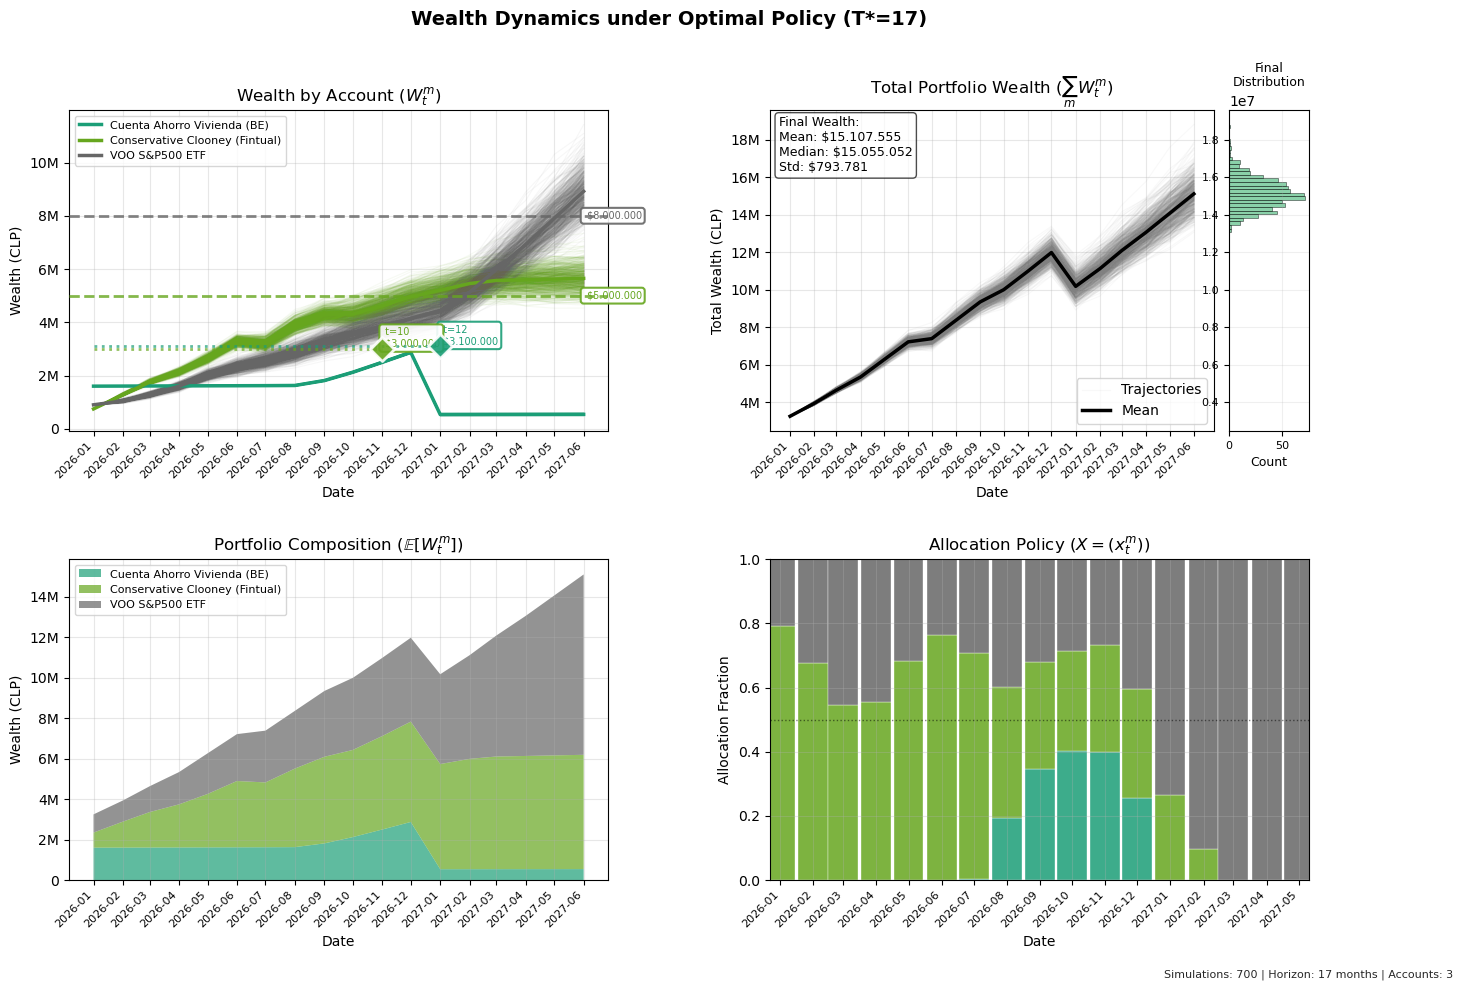

In [11]:
# --- Plot: Wealth Dynamics ---

model.plot(
    mode='wealth',
    result=opt_sim,
    X=opt_result.X,
    title=f"Wealth Dynamics under Optimal Policy (T*={opt_result.T})",
    show_trajectories=True,
    goals=goals
)

/home/mlioi/fin-opt/src/plotting.py:766: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.05, 1, 0.97 if title else 0.99])


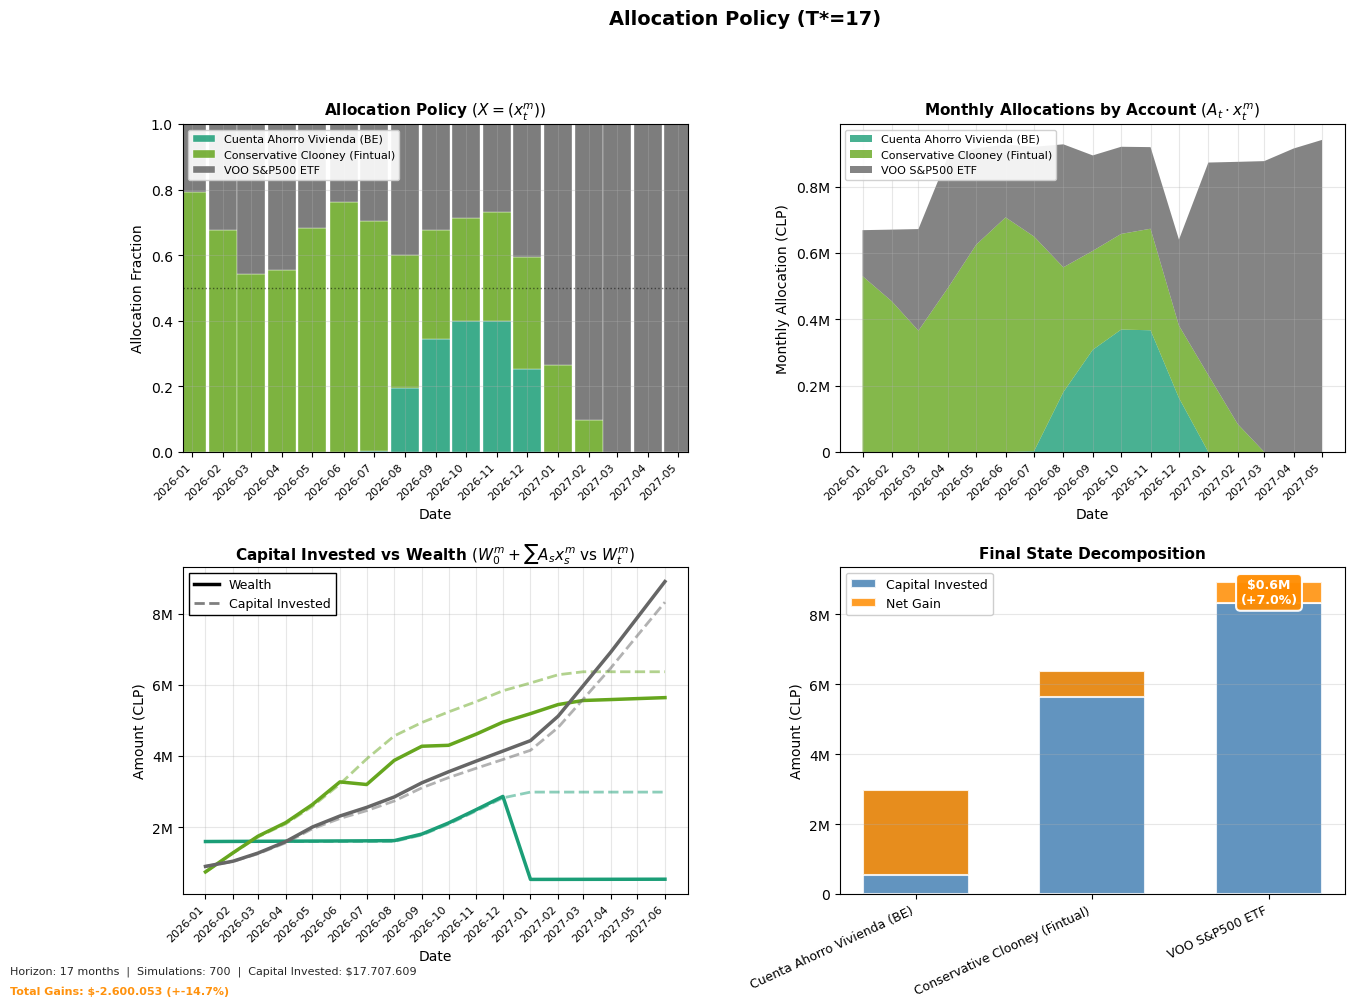

In [12]:
# --- Plot: Allocation Policy ---

model.plot(
    mode='allocation',
    result=opt_sim,
    X=opt_result.X,
    title=f"Allocation Policy (T*={opt_result.T})",
    show_trajectories=False
)

---
# 8. Goal Verification

In [13]:
# --- Out-of-Sample Goal Verification ---

print("=" * 70)
print("GOAL VERIFICATION (Out-of-Sample)")
print("=" * 70)
print(f"Using {opt_sim.n_sims} fresh scenarios (seed=999)\n")

goal_status = model.verify_goals(opt_sim, goals, start=START_DATE)

for goal, metrics in goal_status.items():
    print(f"Account: {goal.account}")
    if isinstance(goal, IntermediateGoal):
        print(f"  Type: Intermediate (month {goal.month})")
    else:
        print(f"  Type: Terminal")
    print(f"  Threshold: ${goal.threshold:,.0f}")
    print(f"  Required confidence: {goal.confidence:.0%}")
    print(f"  ---")
    status = "SATISFIED" if metrics['satisfied'] else "VIOLATED"
    symbol = "[OK]" if metrics['satisfied'] else "[!!]"
    print(f"  {symbol} Status: {status}")
    print(f"  Violation rate: {metrics['violation_rate']:.1%} (required <= {metrics['required_rate']:.1%})")
    print(f"  Margin: {metrics['margin']:.1%}")
    print()

print("=" * 70)

GOAL VERIFICATION (Out-of-Sample)
Using 700 fresh scenarios (seed=999)

Account: Clooney
  Type: Terminal
  Threshold: $5,000,000
  Required confidence: 50%
  ---
  [OK] Status: SATISFIED
  Violation rate: 4.7% (required <= 50.0%)
  Margin: 45.3%

Account: VOO
  Type: Terminal
  Threshold: $8,000,000
  Required confidence: 50%
  ---
  [OK] Status: SATISFIED
  Violation rate: 7.9% (required <= 50.0%)
  Margin: 42.1%

Account: Vivienda
  Type: Intermediate (month 12)
  Threshold: $3,100,000
  Required confidence: 50%
  ---
  [!!] Status: VIOLATED
  Violation rate: 100.0% (required <= 50.0%)
  Margin: -50.0%

Account: Clooney
  Type: Intermediate (month 10)
  Threshold: $3,000,000
  Required confidence: 50%
  ---
  [OK] Status: SATISFIED
  Violation rate: 0.0% (required <= 50.0%)
  Margin: 50.0%



---
# 9. Compare Scenarios (Optional)

Load a previously saved scenario and compare results.

In [14]:
# --- Load Saved Scenario ---

# This demonstrates how to reload a scenario
loaded_scenario = load_scenario(scenario_path)

print(f"Loaded scenario: {loaded_scenario['name']}")
print(f"Description: {loaded_scenario['description']}")
print(f"Start date: {loaded_scenario['start_date']}")
print(f"Goals: {len(loaded_scenario['goals'])}")
print(f"Withdrawals: {loaded_scenario['withdrawals']}")
print(f"Simulation config: n_sims={loaded_scenario['simulation'].n_sims}")
print(f"Optimization config: T_max={loaded_scenario['optimization'].T_max}")

Loaded scenario: House Purchase 2026
Description: Planning for apartment down payment with emergency fund maintenance
Start date: 2025-11-01
Goals: 4
Withdrawals: WithdrawalModel(scheduled=2, stochastic=1)
Simulation config: n_sims=500
Optimization config: T_max=120


---
# Summary

This scenario optimization found:

| Result | Value |
|--------|-------|
| **Minimum Horizon T*** | See optimization output |
| **Optimal Allocation X*** | Shown in allocation plot |
| **Goal Satisfaction** | Verified out-of-sample |

**Key insights from the allocation policy:**
- The optimizer balances contributions across accounts to meet all goals
- Intermediate goals require early wealth accumulation in specific accounts
- Terminal goals drive long-term allocation strategy

**Next steps:**
- Modify goals/withdrawals and re-run to compare scenarios
- Increase `n_sims` for more robust results
- Try different objectives (`risky`, `conservative`, `risky_turnover`)